In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1013. Microbiome Peanut Allergy/P1013.3. Analyses/P1013.4. Outcome Prediction/Output')
cur_date = "092525"

library(readxl)
library(tidyverse)
library(factoextra)
# library(gtsummary)
# library(caret)
# library(e1071)
# library(Hmisc)
# library(randomForest)
# library(pROC)
# library(themis)

# reading in files
saliva_df = data.frame(read_excel("Input/Processed_Saliva_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE)) 
stool_df = data.frame(read_excel("Input/Processed_Stool_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE)) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [18]:
`%notin%` <- Negate(`%in%`)

paired_saliva_df = saliva_df  %>%
    # removing those failed the IgE protein
    filter(IgE_Binarized != 'Fail')  %>%
    # ended up reassinging 'DS' to 'F' due to small sample size
     mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    # removing 13 participants that don't have pre and post samples
    # keeping subject 20, 24, 26 that have post but not pre data
    filter(#Subject_No %notin% c(1,12,13,16,17,31,32,36,37,43),
    # retaining those given treatment
          Treatment == 'A') %>%
    # normalizing
    mutate(across(10:ncol(saliva_df), ~ log(.x + 2))) %>%
    column_to_rownames('Sample_ID')

paired_stool_df = stool_df  %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
     # removing 10 participants that don't have pre and post samples
    # keeping subject 3, 10 that have post but not pre data
    filter(#Subject_No %notin% c(14,15,23,25,27,32,35,39),
          Treatment == 'A') %>%
    mutate(across(11:ncol(stool_df), ~ log(.x + 2))) %>%
    column_to_rownames('Sample_ID')

head(paired_saliva_df)

,Original_Sample_ID,Subject_No,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Post_2,FS0236mo,2,Post,A,F,1.873973,14.20,Low,4.1743873,3.2958369,⋯,6.5510803,0.6931472,3.8066625,4.605170,7.413970,0.6931472,0.6931472,6.0520892,4.9972123,4.828314
Pre_2,FS02baseline,2,Pre,A,F,1.873973,14.20,Low,0.6931472,2.8903718,⋯,0.6931472,0.6931472,3.8712010,5.921578,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.736198
Post_4,FS0536mo,4,Post,A,F,3.991781,9.59,Low,2.0794415,0.6931472,⋯,0.6931472,2.9444390,0.6931472,4.948760,7.833204,0.6931472,0.6931472,6.2225763,3.7135721,4.634729
Pre_4,FS05baseline,4,Pre,A,F,3.991781,9.59,Low,3.2580965,0.6931472,⋯,0.6931472,0.6931472,0.6931472,4.718499,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.129899
Post_6,FS0736mo,6,Post,A,SU,1.419178,1.32,Low,1.3862944,3.2580965,⋯,0.6931472,0.6931472,0.6931472,6.142037,7.407318,2.1972246,0.6931472,5.1298987,4.1431347,6.084499
Pre_6,FS07baseline,6,Pre,A,SU,1.419178,1.32,Low,2.1972246,0.6931472,⋯,0.6931472,0.6931472,0.6931472,7.748029,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.401197


# PCA based on Time Point recieving Active Treatment

Note: For this analysis, I included participants that only pre or post data to maximize the sample size.

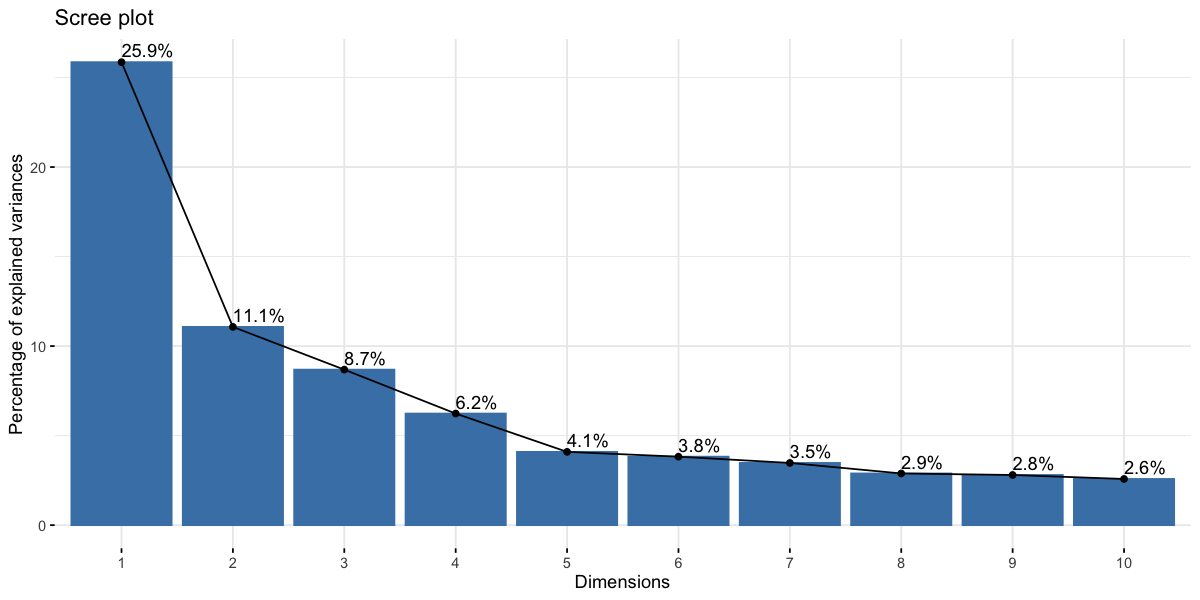

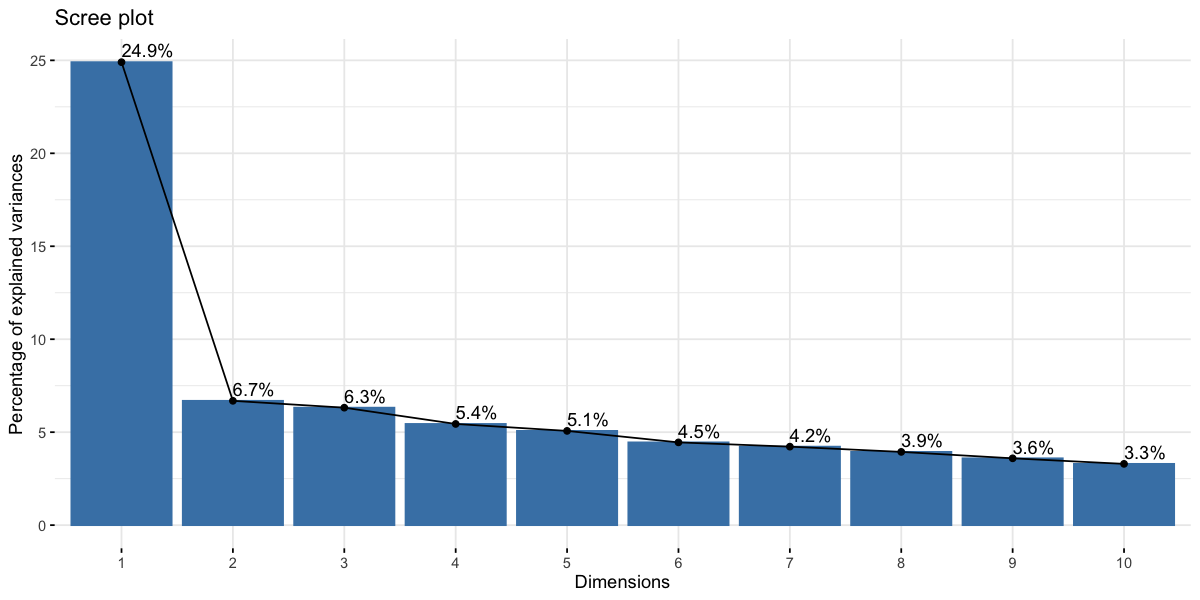

In [19]:
# setting seed for reproducibility
set.seed(12)

pca_saliva_df = paired_saliva_df[,9:ncol(paired_saliva_df)]
pca_stool_df = paired_stool_df[,10:ncol(paired_stool_df)]

# running pca 
saliva_pca = prcomp(pca_saliva_df)#, center = TRUE, scale = TRUE)
stool_pca = prcomp(pca_stool_df)#, center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(saliva_pca, addlabels = TRUE)
fviz_eig(stool_pca, addlabels = TRUE)

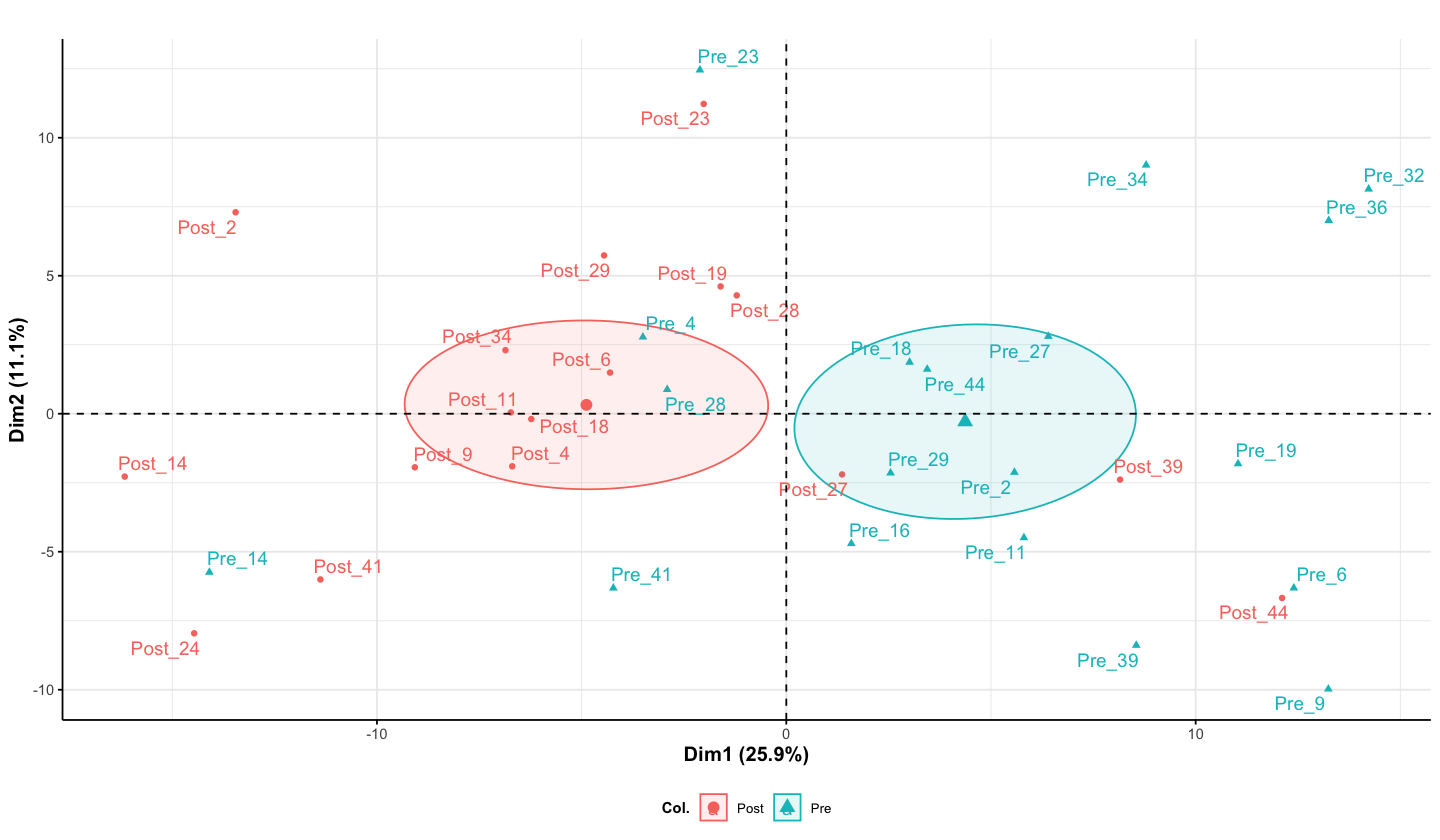

In [21]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(saliva_pca, 
             col.ind = paired_saliva_df$Time_Point, # color by Group
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

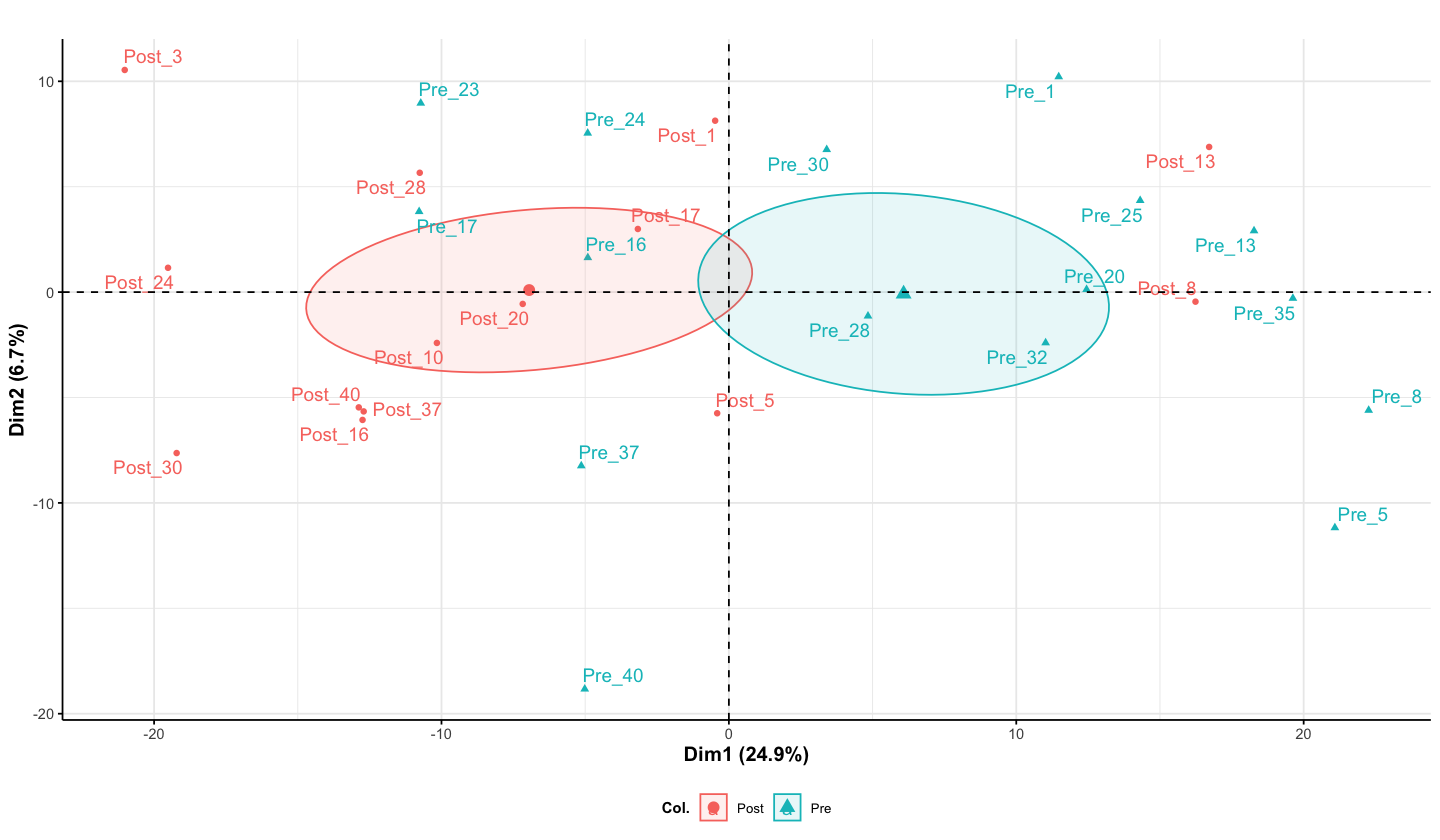

In [22]:
fviz_pca_ind(stool_pca, 
             col.ind = paired_stool_df$Time_Point, # color by Group
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

In [23]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA subject outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x[,1:2]
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
subject_outliers_saliva = outlier_detection(saliva_pca)
subject_outliers_stool = outlier_detection(stool_pca)            
subject_outliers_saliva
subject_outliers_stool

character(0)

character(0)

# Comparing Baseline Bacteria Abundances

In [24]:
combined_saliva_df = saliva_df  %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    filter(IgE_Binarized != 'Fail')
combined_stool_df = stool_df  %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    filter(IgE_Binarized != 'Fail')

v1_saliva_df = combined_saliva_df %>%
    # only keep participants' baseline samples and those given active treatment
    filter(Time_Point == 'Pre' & Treatment == 'A') %>%
    # making the row names the sample ids
    column_to_rownames(var = 'Sample_ID')

v1_stool_df = combined_stool_df %>%
    filter(Time_Point == 'Pre' & Treatment == 'A') %>%
    column_to_rownames(var = 'Sample_ID')

head(v1_saliva_df)

,Original_Sample_ID,Subject_No,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pre_2,FS02baseline,2,Pre,A,F,1.873973,14.20,Low,0,16,⋯,0,0,46,371,3359,0,0,0,0,112
Pre_4,FS05baseline,4,Pre,A,F,3.991781,9.59,Low,24,0,⋯,0,0,0,110,1225,40,4,403,35,167
Pre_6,FS07baseline,6,Pre,A,SU,1.419178,1.32,Low,7,0,⋯,0,0,0,2315,1978,0,16,0,5,28
Pre_9,FS10baseline,9,Pre,A,SU,1.389041,0.42,Low,9,0,⋯,0,0,0,1450,4274,0,0,0,0,7
Pre_11,FS12baseline,11,Pre,A,F,1.567123,4.34,Low,8,0,⋯,0,0,0,16,4652,0,0,37,7,31
Pre_14,FS15baseline,14,Pre,A,F,3.912329,105.00,High,2,0,⋯,8,0,0,33,262,0,0,1465,58,56


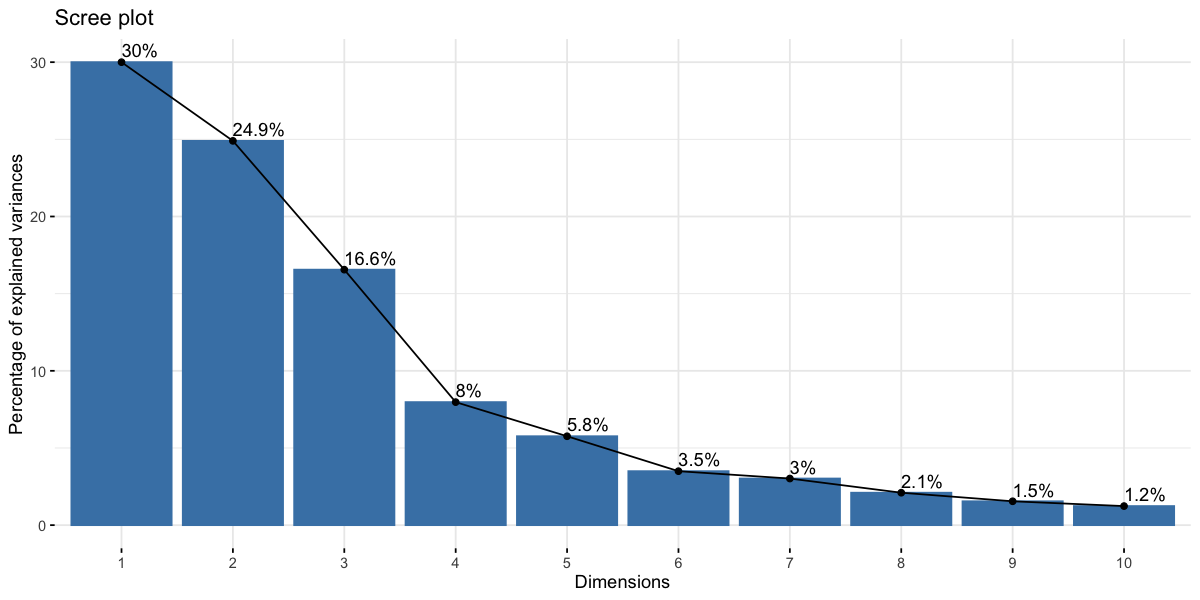

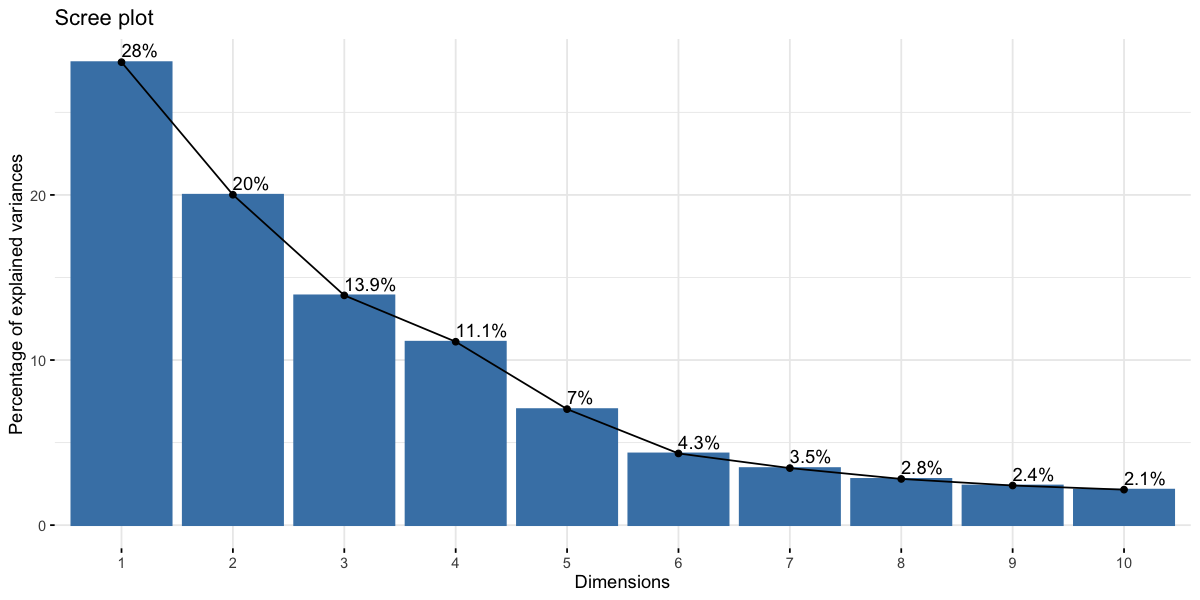

In [25]:
# setting seed for reproducibility
set.seed(12)

pca_saliva_df = v1_saliva_df[,9:ncol(v1_saliva_df)]
pca_stool_df = v1_stool_df[,10:ncol(v1_stool_df)]

# running pca 
saliva_pca = prcomp(pca_saliva_df)#, center = TRUE, scale = TRUE)
stool_pca = prcomp(pca_stool_df)#, center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(saliva_pca, addlabels = TRUE)
fviz_eig(stool_pca, addlabels = TRUE)

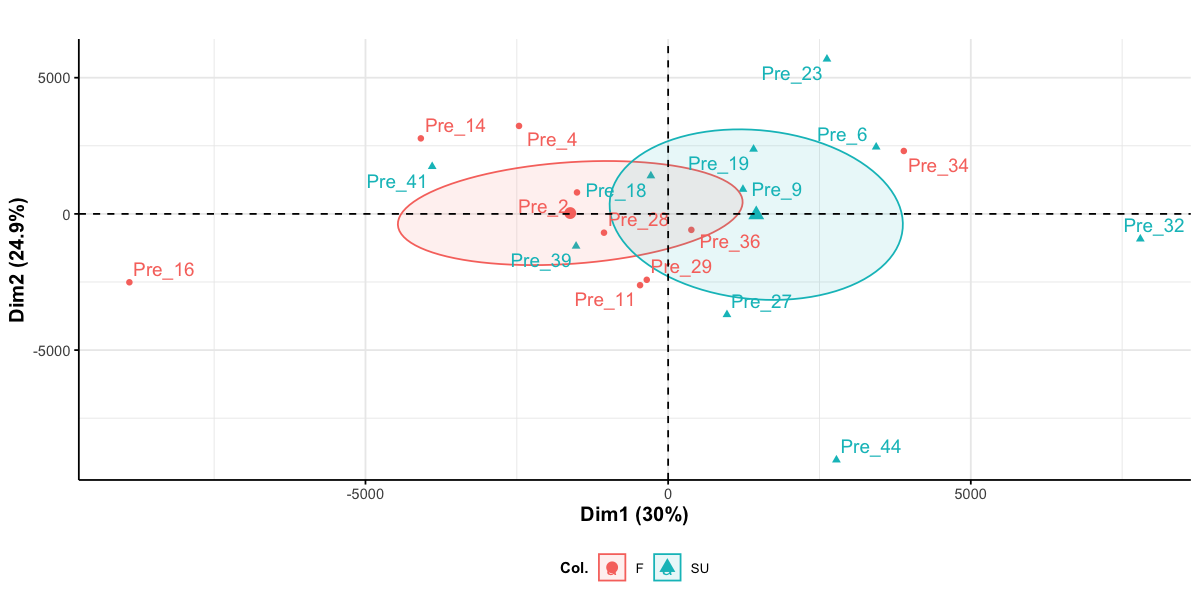

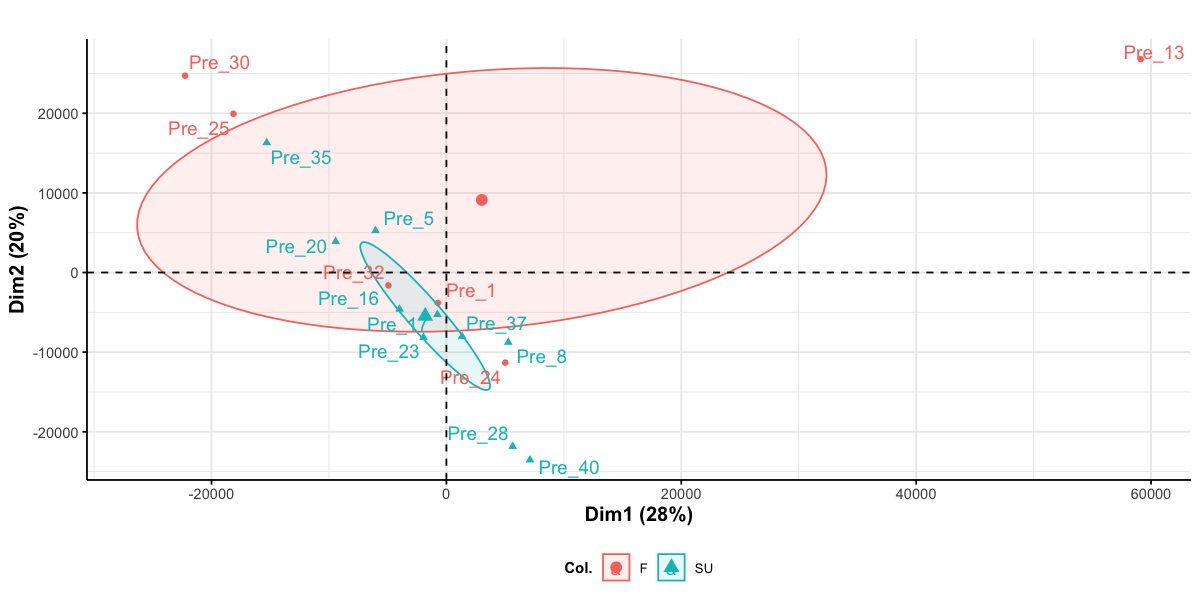

In [28]:
fviz_pca_ind(saliva_pca, 
             col.ind = v1_saliva_df$Outcome, # color by Group
             # adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

fviz_pca_ind(stool_pca, 
             col.ind = v1_stool_df$Outcome, # color by Group
             # #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

In [27]:
# calling fn
subject_outliers_saliva = outlier_detection(saliva_pca)
subject_outliers_stool = outlier_detection(stool_pca)  
subject_outliers_saliva
subject_outliers_stool

character(0)

character(0)